<a href="https://colab.research.google.com/github/rodrigoclira/mineracao-dados/blob/main/methods_for_dealing_with_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos para lidar com dados desbalanceados

Classes desequilibradas são um problema comum na classificação de aprendizado de máquina, onde há uma proporção desproporcional de observações em cada classe. O desequilíbrio de classe pode ser encontrado em muitas áreas diferentes, incluindo diagnóstico médico, filtragem de spam e detecção de fraude.

Neste guia, veremos cinco maneiras possíveis de lidar com um problema de classe desequilibrada usando dados de cartão de crédito. Nosso objetivo será classificar corretamente a classe minoritária de transações fraudulentas.

Nota importante:
Este guia se concentrará apenas no tratamento de classes desequilibradas e não abordará outras etapas importantes de aprendizado de máquina, incluindo, mas não se limitando a, seleção de recursos ou ajuste de hiperparâmetros.

Dataset utilizado (baixe-o e importe no painel lateral)
https://drive.google.com/file/d/1NP3ba6weG66mF7wl56bT5UVTSdmQ-hlg/view

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [2]:
# configurando parâmetros de plotagem padrão
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [4]:
!unzip creditcard.zip #certifique que o arquivo credicard.zip foi upado no painel lateral

Archive:  creditcard.zip
  inflating: creditcard.csv          


In [7]:
# read in data
df = pd.read_csv('creditcard.csv')

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


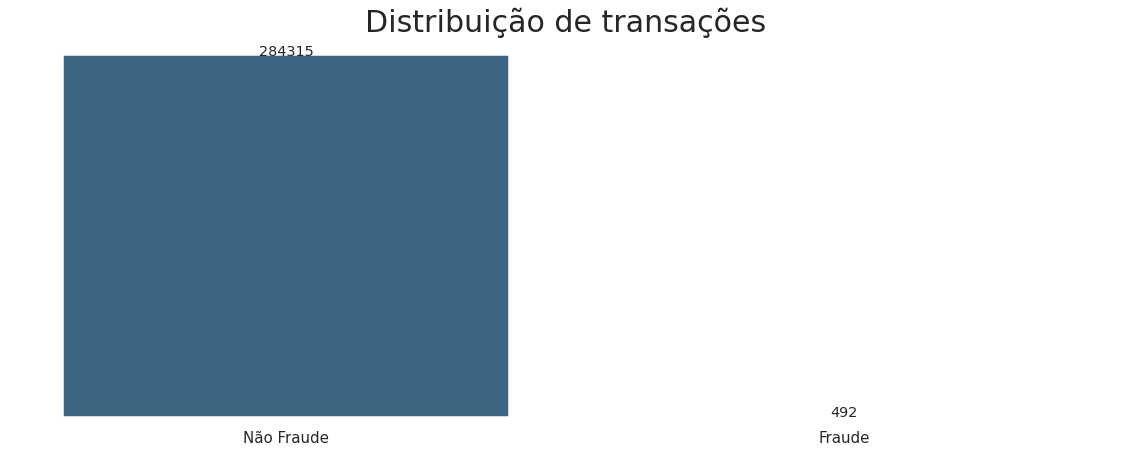

In [9]:
# usando seaborn countplot para mostrar a distribuição de perguntas no conjunto de dados
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Não Fraude', 'Fraude'])
g.set_yticklabels([])

# Função para mostrar valores no gráfico de barra
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribuição de transações', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [10]:
# print percentage of questions where target == 1
(len(df.loc[df.Class==1])) / (len(df.loc[df.Class == 0])) * 100

0.17304750013189596

A partir do gráfico acima, podemos ver que temos uma classe muito desequilibrada - apenas 0,17% do nosso conjunto de dados pertence à classe alvo!

Isso é um problema porque muitos modelos de aprendizado de máquina são projetados para maximizar a precisão geral, o que especialmente com classes desequilibradas pode não ser a melhor métrica a ser usada. A precisão da classificação é definida como o número de previsões corretas dividido pelo total de previsões vezes 100. Por exemplo, se simplesmente previssemos que todas as transações não são fraude, obteríamos uma pontuação de precisão de classificação superior a 99%!

### Criar conjuntos de treinamento e teste

O conjunto de treinamento é usado para construir e validar o modelo, enquanto o conjunto de teste é reservado para testar o modelo em dados não vistos.

In [12]:
# Preparar dados para modelagem
# entrada e 'alvo' separados
y = df.Class
X = df.drop('Class', axis=1)

# configurar conjuntos de teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

## Modelos Base

In [13]:
# DummyClassifier para prever apenas o alvo 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# verificando rótulos exclusivos
print('Rótulos previstos exclusivos: ', (np.unique(dummy_pred)))

# verificando a precisão
print('Score de teste: ', accuracy_score(y_test, dummy_pred))

Rótulos previstos exclusivos:  [0]
Score de teste:  0.9981461194910255


Conforme previsto, nossa pontuação de precisão para classificar todas as transações como não fraude é de 99,8%!

Como o Classificador Dummy prevê apenas a Classe 0, claramente não é uma boa opção para nosso objetivo de classificar corretamente as transações fraudulentas.

Vamos ver como a regressão logística se comporta nesse conjunto de dados.

In [14]:
# Modelando os dados como estão
# Treinando modelo
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Prevendo no conjunto de teste
lr_pred = lr.predict(X_test)

In [15]:
# Checando Acurácia
accuracy_score(y_test, lr_pred)

0.9992135052386169

In [16]:
# Verificando valores únicos
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    71108
1       94
Name: 0, dtype: int64

A regressão logística superou o classificador fictício! Podemos ver que ele previu 94 instâncias da classe 1, então isso é definitivamente uma melhoria. Mas podemos fazer melhor?

Vamos ver se podemos aplicar algumas técnicas para lidar com o desequilíbrio de classes para melhorar esses resultados.

## 1.  Alterar a métrica de desempenho

A precisão não é a melhor métrica a ser usada ao avaliar conjuntos de dados desequilibrados, pois pode ser enganosa. As métricas que podem fornecer melhores insights incluem:
 - **Confusion Matrix:**  uma tabela mostrando previsões corretas e tipos de previsões incorretas.
 - **Precision: **  o número de verdadeiros positivos dividido por todas as previsões positivas. A precisão também é chamada de Valor Preditivo Positivo. É uma medida da exatidão de um classificador. Baixa precisão indica um alto número de falsos positivos.
 - **Recall:**  o número de verdadeiros positivos dividido pelo número de valores positivos nos dados de teste. O recall também é chamado de Sensibilidade ou Taxa de Verdadeiro Positivo. É uma medida da completude de um classificador. Baixo recall indica um alto número de falsos negativos.
 - **F1: Score:** a média ponderada de precisão e recall.
 
Como nosso principal objetivo com o conjunto de dados é priorizar a classificação precisa dos casos de fraude, a pontuação de recall pode ser considerada nossa principal métrica a ser usada para avaliar os resultados.

In [ ]:
# f1 score
f1_score(y_test, lr_pred)

In [ ]:
# Matriz de confusão
pd.DataFrame(confusion_matrix(y_test, lr_pred))

In [ ]:
recall_score(y_test, lr_pred)

Temos uma pontuação de precisão muito alta de 0,999, mas uma pontuação F1 de apenas 0,752. E a partir da matriz de confusão, podemos ver que estamos classificando incorretamente várias observações levando a uma pontuação de recordação de apenas 0,64.

## 2. Mude o algoritmo

Embora em todos os problemas de aprendizado de máquina seja uma boa regra geral tentar uma variedade de algoritmos, pode ser especialmente benéfico com conjuntos de dados desequilibrados. As árvores de decisão geralmente têm bom desempenho em dados desequilibrados. Eles trabalham aprendendo uma hierarquia de perguntas if/else. Isso pode forçar ambas as classes a serem endereçadas.


In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# treinando modelo
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# prevendo no conjunto de teste
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.999592708069998

In [22]:
# f1 score
f1_score(y_test, rfc_pred)

0.8786610878661087

In [23]:
# Matriz de Confusão
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

,0,1
0,71068,2
1,27,105


In [24]:
# recall score
recall_score(y_test, rfc_pred)

0.7954545454545454

# Técnicas de Reamostragem

## 3. Oversampling da classe minoritária
A sobreamostragem pode ser definida como a adição de mais cópias da classe minoritária. A sobreamostragem pode ser uma boa opção quando você não tem muitos dados para trabalhar. Um contra a ser considerado ao fazer a subamostragem é que ela pode causar overfitting e generalização ruim para seu conjunto de teste.

Usaremos o módulo de reamostragem do Scikit-Learn para replicar aleatoriamente amostras da classe minoritária.

### **Informação Importante**
Sempre divida em conjuntos de teste e treinamento ANTES de tentar qualquer técnica de reamostragem! A sobreamostragem antes de dividir os dados pode permitir que exatamente as mesmas observações estejam presentes nos conjuntos de teste e de trem! Isso pode permitir que nosso modelo simplesmente memorize pontos de dados específicos e cause overfitting.

In [25]:
from sklearn.utils import resample

In [26]:
# Separando  features de entrada e alvo
y = df.Class
X = df.drop('Class', axis=1)

# Separando o conjunto de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [27]:
# Concatenando os dados de treino novamente
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [28]:
# separando classe minoritária e majoritária
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample classe minoritária
fraud_upsampled = resample(fraud,
                          replace=True, # amostragem com reposição
                          n_samples=len(not_fraud), # Ser o mesmo número da classe maioritária
                          random_state=27) # Resultados podem ser reproduzidos (mesmo random_state)

# combinando classe majoritária e a classe minoritária upsampled
upsampled = pd.concat([not_fraud, fraud_upsampled])

# checando a contagem 
upsampled.Class.value_counts()

0    213245
1    213245
Name: Class, dtype: int64

In [29]:
# tentando logistic regression com o banco de dados balanceado
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

In [30]:
# Checando acurácia
accuracy_score(y_test, upsampled_pred)

0.9807589674447347

In [31]:
# f1 score
f1_score(y_test, upsampled_pred)

0.14375000000000002

In [32]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))

,0,1
0,69717,1353
1,17,115


In [33]:
recall_score(y_test, upsampled_pred)

0.8712121212121212

Nossa pontuação de precisão diminuiu após o upsampling, mas o modelo agora está prevendo as duas classes de forma mais igual, tornando-se uma melhoria em relação à nossa regressão logística simples acima.


## 4. Undersampling da classe majoritária
A subamostragem pode ser definida como a remoção de algumas observações da classe majoritária. A subamostragem pode ser uma boa escolha quando você tem uma tonelada de dados – pense em milhões de linhas. Mas uma desvantagem da subamostragem é que estamos removendo informações que podem ser valiosas.

Usaremos novamente o módulo de reamostragem do Scikit-Learn para remover amostras aleatoriamente da classe majoritária.

In [34]:
# ainda usando as classes separadsa de fraude and not_fraud criadas acima

# downsample a classe majoritária
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# Combinando a minoritária e a majoritária downsampled
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

0    360
1    360
Name: Class, dtype: int64

In [35]:
# Tentando a regressão logística novamente com undersampled dataset

y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

In [36]:
# Checando acurácia
accuracy_score(y_test, undersampled_pred)

0.9758574197354007

In [37]:
# f1 score
f1_score(y_test, undersampled_pred)

0.11710323574730355

In [38]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, undersampled_pred))

,0,1
0,69369,1701
1,18,114


In [39]:
recall_score(y_test, undersampled_pred)

0.8636363636363636

Downsampling produziu uma pontuação de recall mais alta do que o upsampling! Minha preocupação aqui é o pequeno número de amostras totais que usamos para treinar o modelo.


## 5. Gerar Amostras Sintéticas
SMOTE ou Synthetic Minority Oversampling Technique é um algoritmo popular para criar observações sintéticas da classe minoritária.

In [42]:
from imblearn.over_sampling import SMOTE

# Separando  features de entrada e alvo
y = df.Class
X = df.drop('Class', axis=1)

# Separando o conjunto de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [43]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

# Checando Acurácia
accuracy_score(y_test, smote_pred)

0.9858571388444145

In [44]:
# f1 score
f1_score(y_test, smote_pred)

0.18461538461538463

In [45]:
# Matriz de confusão
pd.DataFrame(confusion_matrix(y_test, smote_pred))

,0,1
0,70081,989
1,18,114


In [46]:
recall_score(y_test, smote_pred)

0.8636363636363636

## Conclusão

Cobrimos 5 métodos diferentes para lidar com conjuntos de dados desequilibrados:

1.  Alterar a métrica de desempenho
2.  Oversampling da classe minoritária
3.  Undersampling da classe majoritária 
4.  Alterar o algoritmo
5.  Gerar amostras sintéticas


Esses são apenas alguns dos muitos métodos possíveis para tentar lidar com conjuntos de dados desequilibrados, e não uma lista exaustiva. Alguns outros métodos a serem considerados são coletar mais dados ou escolher diferentes proporções de reamostragem - você não precisa ter exatamente uma proporção de 1:1! Você deve sempre tentar várias abordagens e depois decidir qual é a melhor para o seu problema.

Referência

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18